In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import random
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1177989684
import tensorflow as tf
import preprocessing_fcts as pp

## Resampling of the rgb image to fit with the dsm and dtm

This step might take time because the file are heavy (5GB each)

In [2]:
dsm = np.array(Image.open('Urbis/UrbDSMY21_RBC_50cm/UrbDSMY21_RBC_50cm.tif'))
dtm = np.array(Image.open('Urbis/UrbDTMY21_RBC_50cm/UrbDTMY21_RBC_50cm.tif'))
rgb = Image.open('Urbis/UrbOrthoY21_RBC_40cm_NS_RGB/UrbOrthoY21_RBC_40cm_NS_RGB.tif')

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (2137500000 pixels) exceeds limit of 1177989684 pixels, could be decompression bomb DOS attack.
  warnings.warn(


cropping and resampling of the orthoplan to be compatible with the DSM. 
A sample of the DSM and orthoplan are shown to see that they align

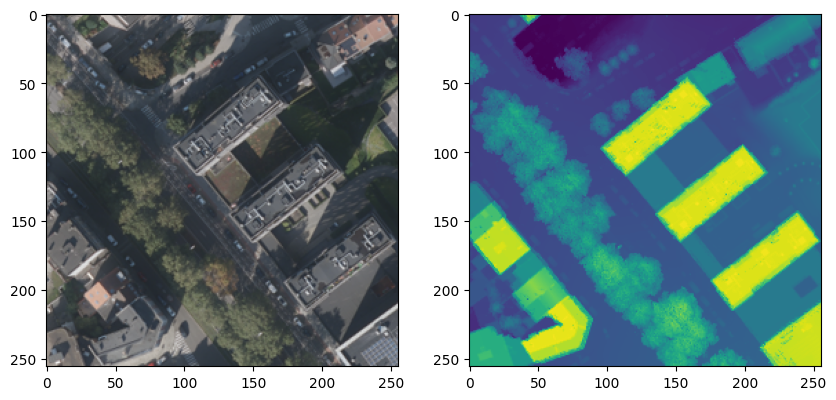

In [5]:
rgb = rgb.resize((38000, 36000)) #the size to go from a resolution of 0.4m to 0.5m
rgb_test = np.array(rgb.crop((1985,1249,38000-1593,36000-529)))
fig=plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(rgb_test[10000:10256,20000:20256])
plt.subplot(1,2,2)
plt.imshow(dsm[10000:10256,20000:20256])
resampled_rgb = Image.fromarray(rgb_test)
resampled_rgb.save('Urbis/50cm_NS_RGB/50cm_NS_RGB.tif')

In [8]:
rgb.close()
del(rgb_test)
resampled_rgb.close()

## Preparation of the numpy datasets

In [9]:
rgb = np.array(Image.open('Urbis/50cm_NS_RGB/50cm_NS_RGB.tif'))

Patches of 512x512 pixels are generated (in a way that no pixel is out of the Brussels map) 

In [10]:
n=0
val = dsm[0][0] #All the pixels out of brussels have the same value of ~-3*10e-38
y = 0 #y coordinate

windows = [] # The coordinate of the upper left pixel of each selected 512x512 patch is recored in 'windows'

for i in range(0, dsm.shape[0]-512,512): # each line, with a step 512. It is correlated with the x coordinate, 
    for j in range(dsm.shape[1]): # but j is not correlated with y
        if y >= dsm.shape[1] - 512: # end of line
            y = 0
            break
        if not val in dsm[i:i+512,y:y+512]: # verify that no pixel out of Brussels is in the patch
            windows.append((i,y)) # if it is the case the patch is included in the list, and a step 512 in the y direction is taken
            y += 512 
            n+=1
        else : 
            y += 1 # there is a pixel out of Brussels in the window, so we make a step of 1 pixel and try again
            
print(n)                  

2562


These patches are randomly split between a 'train', 'test' and 'val' dataset 

In [13]:
def list_dif(list1, list2):
    res = list1
    for item in list2:
        res.remove(item)
    return res

items = list(range(n))
train = random.sample(items, int(0.85*n)) #train, test and val contain the indices of the items in windows selected to be in the training, testing and validation sets
items = list_dif(items, train)
test = random.sample(items, int(0.1*n))
val = list_dif(items, test)

From each patch, 4 256x256 patches are generated <br>
4 types of datasets are made : <br>
    - Resolution = 256x256 or 512x512 <br>
    - Just DSM or DSM concatenated with RGB image <br>
For both resolutions, the corresponding DTM (the supervision) to each patch is saved as well

In [14]:
def save_images(windows, sample, name):
    
    """
    Uses the list "windows" to save as numpy arrays the images of the different datasets
    Saves dataset of images with 512x512 pixels and dataset with the same images divided in 4 (with 256x256 pixels)
    For each item of the dataset, 1 image with the DSM, 1 with DSM+ rgb channels of the orthophotograph and 1 DTM are saved
    images_list : list with the coordinate of the upper left corner of the 512x512 pixels images patches
    sample : list of indices of images to sample from images_list (indices of images either from training, testing or validation datasets)
    name : string 'train', 'test' or 'val'
    """
    
    id512 = 1
    id256 = 1
    for index in sample: 
        w = windows[index] # Coordinates of the upper left pixel of the selected patch
        arr = dsm[w[0]:w[0]+512,w[1]:w[1]+512] # np array of the patch from the dsm
        arr_dtm = dtm[w[0]:w[0]+512,w[1]:w[1]+512]
        arr_rgb = np.concatenate((arr.reshape(arr.shape[0], arr.shape[1],1), rgb[w[0]:w[0]+512,w[1]:w[1]+512]), axis=2) # concatenation of dsm and rgb, to obtain array of shape 512x512x4 
        #np.save('np_dataset/512/' + name + '/' + str(id512), arr)
        np.save('np_dataset/512/' + name + '/' + str(id512), arr_rgb)
        np.save('np_dataset/512/' + name + '/dtm_' + str(id512), arr_dtm)
        id512+=1
        for i in range(2): #for each 512x512 patch, 4 256x256 are saved in their corresponding dataset as well
            for j in range(2):
                arr_256 = arr[i*256:(i+1)*256, j*256:(j+1)*256]
                arr_256_rgb = arr_rgb[i*256:(i+1)*256, j*256:(j+1)*256, :]
                arr_dtm_256 = arr_dtm[i*256:(i+1)*256, j*256:(j+1)*256]
                #np.save('np_dataset/256/' + name + '/' + str(id256), arr_256)
                np.save('np_dataset/256/' + name + '/' + str(id256), arr_256_rgb)
                np.save('np_dataset/256/' + name + '/dtm_' + str(id256), arr_dtm_256)
                id256 += 1
        print(str(id512), end="\r")
        time.sleep(.05)
    return 0

In [16]:
#save_images(windows, train, 'train')
#print('done train')
#save_images(windows, test, 'test')
#print('done test')
save_images(windows, val, 'val')

0

## Conversion of the numpy dataset into tensorflow datasets

The tensorflow datasets are saved in the directory 'tf_dataset'

In [ ]:
train_dataset_512 = pp.make_tf_dataset(512, 'train', True)
train_dataset_512.save('tf_dataset/train_dataset_512')

test_dataset_512 = pp.make_tf_dataset(512, 'test', True)
test_dataset_512.save('tf_dataset/test_dataset_512')

train_dataset_256 = pp.make_tf_dataset(256, 'train', True)
train_dataset_256.save('tf_dataset/train_dataset_256')

test_dataset_256 = pp.make_tf_dataset(256, 'test', True)
test_dataset_256.save('tf_dataset/test_dataset_256')

In [7]:
val_dataset_512 = pp.make_tf_dataset(512, 'val')
val_dataset_512.save('tf_dataset/val_dataset_256')

In [6]:
for i in val_dataset_512.take(1):
    print(i)

(<tf.Tensor: shape=(512, 512, 4), dtype=float32, numpy=
array([[[ 88.80118 ,  27.      ,  33.      ,  36.      ],
        [ 88.80845 ,  27.      ,  33.      ,  37.      ],
        [ 88.80575 ,  28.      ,  32.      ,  37.      ],
        ...,
        [103.42494 , 196.      , 195.      , 194.      ],
        [103.38962 , 186.      , 186.      , 185.      ],
        [103.37034 , 166.      , 171.      , 176.      ]],

       [[ 88.79452 ,  29.      ,  33.      ,  36.      ],
        [ 88.80094 ,  29.      ,  33.      ,  35.      ],
        [ 88.81164 ,  33.      ,  34.      ,  34.      ],
        ...,
        [103.154175, 193.      , 193.      , 191.      ],
        [103.10088 , 187.      , 187.      , 186.      ],
        [103.07758 , 173.      , 174.      , 175.      ]],

       [[ 91.865845,  31.      ,  37.      ,  42.      ],
        [ 92.88492 ,  49.      ,  51.      ,  55.      ],
        [ 95.446365,  94.      ,  95.      ,  94.      ],
        ...,
        [102.83555 , 189.      